# Can we force a 0.5 ROC by randomizing the data?

Randomize our labels, as well as systemic flipping during training.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression

from glob import glob
import seaborn as sns
from collections import defaultdict

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [4]:
%matplotlib inline

In [5]:
np.random.seed(20171101)

## Read deepwalk embeddings

In [6]:
sizes = list(2**i for i in range(3, 9))

In [7]:
sizes

[8, 16, 32, 64, 128, 256]

In [8]:
features = {}
for vecsize in sizes:
    fname = "../embeddings/normal_{}.txt".format(vecsize)

    features[vecsize] = pd.read_csv(
        fname, sep=" ", skiprows=1,
        names=["uid"] + ["f{}".format(i) for i in range(vecsize)]
    )

## Read training data

In [9]:
traind = pd.read_csv("../data/clean_train.tsv", sep='\t')

In [10]:
traind.shape

(138639, 5)

In [11]:
traind.head(3)

,chemical_id,disease_id,category,chemical_uid,disease_uid
0,DB00035,ORPHA:100054,0,22434,989
1,DB00104,ORPHA:100054,0,3845,989
2,DB00115,ORPHA:100054,0,54459,989


In [12]:
traind["category"].value_counts()

0    137008
1      1631
Name: category, dtype: int64

## Randomize training data labels

But keep the proportions constant.

In [13]:
mapping = (pd
    .read_csv("../data/node_map.tsv", sep='\t')
    [["uid", ":ID"]]
    .rename(columns={":ID": "node_id"})
)

In [14]:
mapping.head()

,uid,node_id
0,0,9247
1,1,GO:0021987
2,2,GO:0032414
3,3,7169
4,4,C0403639


In [15]:
labels = list(traind["category"])
np.random.shuffle(labels)

chems = list(traind["chemical_id"])
np.random.shuffle(chems)

dises = list(traind["disease_id"])
np.random.shuffle(dises)

rand_train = pd.DataFrame(
    list(zip(chems, dises, labels)),
    columns=["chemical_id", "disease_id", "category"]
)

In [16]:
rand_train.head()

,chemical_id,disease_id,category
0,DB01501,ORPHA:459353,0
1,DB00622,ORPHA:330,0
2,DB00915,ORPHA:265,0
3,DB08913,ORPHA:79233,0
4,DB00999,ORPHA:34517,0


In [17]:
rand_train = (rand_train
    .merge(
        mapping, how="inner", left_on="chemical_id", right_on="node_id"
    )
    .drop("node_id", axis=1)
    .rename(columns={"uid": "chemical_uid"})
    .merge(
        mapping, how="inner", left_on="disease_id", right_on="node_id"
    )
    .drop("node_id", axis=1)
    .rename(columns={"uid": "disease_uid"})
)

In [18]:
rand_train.head()

,chemical_id,disease_id,category,chemical_uid,disease_uid
0,DB01501,ORPHA:459353,0,53399,19652
1,DB01501,ORPHA:459353,0,53399,19652
2,DB01501,ORPHA:459353,0,53399,19652
3,DB01501,ORPHA:459353,0,53399,19652
4,DB00622,ORPHA:459353,1,19162,19652


In [19]:
rand_train.shape

(138639, 5)

In [20]:
rand_train.drop_duplicates().shape

(91706, 5)

## ok, prob not the right way to do things, but let's try it and see what we get

### Check for amount overlap

In [21]:
(rand_train
    .query("category == 1")
    .merge(
        traind.query("category == 1"),
        how="inner", on=["chemical_id", "disease_id"]
    )
).shape

(10, 8)

In [22]:
holdoutd = pd.read_csv("../data/clean_holdout.tsv", sep='\t')

In [23]:
a = rand_train.merge(holdoutd, how="inner", on=["chemical_id", "disease_id"])

In [24]:
a.shape

(11128, 8)

In [25]:
b = (rand_train
    .query("category == 1")
    .merge(
        holdoutd, how="inner",
        on=["chemical_id", "disease_id"]
    )
)

In [26]:
b.shape

(159, 8)

In [27]:
(b["category_x"] == b["category_y"]).sum()

5

## Subsample random training data

In [28]:
trainpos = rand_train.query("category == 1")
K = 3

train = (trainpos
    .append(
        (rand_train
            .query("category == 0")
            .sample(len(trainpos) * K)
        )
    )
    .reset_index(drop=True)
)

In [29]:
train.head()

,chemical_id,disease_id,category,chemical_uid,disease_uid
0,DB00622,ORPHA:459353,1,19162,19652
1,DB01160,ORPHA:459353,1,17635,19652
2,DB01382,ORPHA:459353,1,12551,19652
3,DB00622,ORPHA:448372,1,19162,31819
4,DB01023,ORPHA:448372,1,1869,31819


In [30]:
train["category"].value_counts(normalize=True)

0    0.75
1    0.25
Name: category, dtype: float64

---

## Add in features

In [31]:
def add_features(df, features):
    return (df
        .merge(
            features, how="inner", left_on="chemical_uid", right_on="uid"
        )
        .drop("uid", axis=1)
        .merge(
            features, how="inner", left_on="disease_uid", right_on="uid"
        )
        .drop("uid", axis=1)
    )

def convolv_features(df, features, vecsize):
    reg = add_features(df, features)
    
    # do multiply and get rid of old features
    for i in range(vecsize):
        reg["conv{}".format(i)] = reg["f{}_x".format(i)] * reg["f{}_y".format(i)]

    reg = (reg
        .drop(
            ["f{}_x".format(i) for i in range(vecsize)], axis=1
        )
        .drop(
            ["f{}_y".format(i) for i in range(vecsize)], axis=1
        )
    )
        
    return reg

In [32]:
tmp = {}
for vecsize, featdf in features.items():
    tmp[vecsize] = convolv_features(train, featdf, vecsize)

## Train classifiers

In [33]:
models = {}
for vecsize, tdata in tmp.items():
    feat_cols = ["conv{}".format(i) for i in range(vecsize)]
    
    models[vecsize] = LogisticRegression(C=1e9)
    models[vecsize].fit(tdata[feat_cols], tdata["category"])

## Predict on holdout data

In [34]:
holdoutd = pd.read_csv("../data/clean_holdout.tsv", sep='\t')

In [35]:
holdoutd.head()

,chemical_id,disease_id,category,chemical_uid,disease_uid
0,DB00035,ORPHA:100050,0,22434,14962
1,DB00104,ORPHA:100050,0,3845,14962
2,DB00121,ORPHA:100050,0,41945,14962
3,DB00131,ORPHA:100050,0,7630,14962
4,DB00139,ORPHA:100050,0,31269,14962


In [36]:
results = {}
for vecsize, regmodel in models.items():
    test = convolv_features(holdoutd.drop("category", axis=1), features[vecsize], vecsize)
    
    featcols = ["conv{}".format(i) for i in range(vecsize)]
    ans = test.assign(predval = lambda df: regmodel.predict_proba(df[featcols])[:, 1])
    
    results[vecsize] = (ans
        [["chemical_id", "disease_id", "predval"]]
        .merge(
            holdoutd[["chemical_id", "disease_id", "category"]],
            how="inner", on=["chemical_id", "disease_id"]
        )
    )

In [37]:
fusion = holdoutd[["chemical_id", "disease_id", "category"]]

for vecsize, res in results.items():
    fusion = (fusion
        .merge(
            res[["chemical_id", "disease_id", "predval"]],
            how="inner", on=["chemical_id", "disease_id"]
        )
        .rename(columns={"predval": "predval{}".format(vecsize)})
    )

In [38]:
fusion.shape

(39288, 9)

In [39]:
fusion.head()

,chemical_id,disease_id,category,predval8,predval16,predval32,predval64,predval128,predval256
0,DB00035,ORPHA:100050,0,0.329189,0.291843,0.252997,0.234140,0.492075,0.224634
1,DB00104,ORPHA:100050,0,0.324213,0.355589,0.308973,0.343023,0.793853,0.668831
2,DB00121,ORPHA:100050,0,0.280373,0.240591,0.199368,0.370417,0.338034,0.308850
3,DB00131,ORPHA:100050,0,0.250429,0.283877,0.178138,0.216159,0.165239,0.059713
4,DB00139,ORPHA:100050,0,0.257552,0.228070,0.194837,0.229062,0.276295,0.077453


---

## Draw ROC curves

In [40]:
def plot_roc(res_df, metrics, name_map, title="ROC"):
    auroc_results = defaultdict(dict)

    for metric in metrics:
        tmp = res_df[["category", metric]].sort_values(metric)
        fpr, tpr, thresh = roc_curve(tmp["category"], tmp[metric])

        auroc_results[metric]['fpr'] = fpr
        auroc_results[metric]['tpr'] = tpr
        auroc_results[metric]['thresh'] = thresh
        auroc_results[metric]['auc'] = auc(fpr, tpr)

    lw = 3
    x = [i for i in np.arange(0.0,1.01,.01)]
    plt.plot(x,x, 'k--', lw = 2)
    for metric in metrics:
        plt.plot(auroc_results[metric]['fpr'], auroc_results[metric]['tpr'], lw=lw,
                 label='{0} (area = {1:0.2f})'
                     .format(name_map[metric], auroc_results[metric]['auc']))
    fig = plt.gcf()
    fig.set_size_inches(8, 7)
    fig.set_tight_layout(False)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel('FPR', size=20)
    plt.ylabel('TPR', size=20)
    plt.title(title, size=24)
    plt.legend(loc="lower right", frameon=True, shadow=True, prop={'size':16});

In [41]:
def plot_pr(res_df, metrics, name_map, title="ROC"):
    auroc_results = defaultdict(dict)

    for metric in metrics:
        tmp = res_df[["category", metric]]
        precision, recall, thresh = precision_recall_curve(tmp["category"], tmp[metric])

        auroc_results[metric]['precision'] = precision
        auroc_results[metric]['recall'] = recall
        auroc_results[metric]['thresh'] = thresh
        auroc_results[metric]['auc'] = auc(recall, precision)

    lw = 3
    x = [i for i in np.arange(0.0,1.01,.01)]
#     plt.plot(x,x, 'k--', lw = lw-4)
    for metric in metrics:
        plt.plot(auroc_results[metric]['recall'], auroc_results[metric]['precision'], lw=lw,
                 label='{0} (area = {1:0.2f})'
                     .format(name_map[metric], auroc_results[metric]['auc']))
    fig = plt.gcf()
    fig.set_size_inches(8, 7)
    fig.set_tight_layout(False)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel('Recall', size=20)
    plt.ylabel('Precision', size=20)
    plt.title(title, size=24)
    plt.legend(loc="upper right", frameon=True, shadow=True, prop={'size':16});

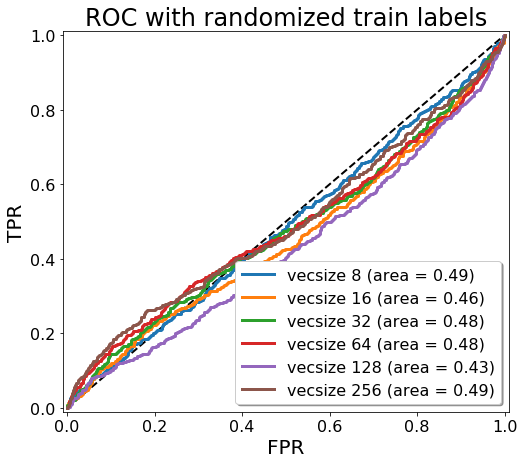

In [42]:
plot_roc(
    fusion,
    ["predval{}".format(i) for i in sizes],
    {
        "predval{}".format(i): "vecsize {}".format(i)
        for i in sizes
    },
    title="ROC with randomized train labels"
)

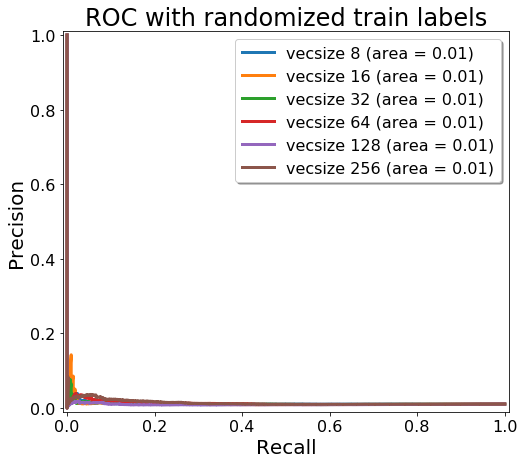

In [43]:
plot_pr(
    fusion,
    ["predval{}".format(i) for i in sizes],
    {
        "predval{}".format(i): "vecsize {}".format(i)
        for i in sizes
    },
    title="ROC with randomized train labels"
)

seems to be working correctly? at least we see no obvious problems when everything's completely scrambled

does this mean it's working correctly??